In [2]:
import json
import re
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# - amount of largest results
take = 40

#admin = 'admin'
#passwd = '!v3G@!4@Y'
#apicip = 'sandboxapicdc.cisco.com'



get_in_packets_url = 'https://' + apicip + '/api/class/eqptIngrPkts5min.json?rsp-subtree=full'
get_in_bytes_url = 'https://' + apicip + '/api/class/eqptIngrBytes5min.json?rsp-subtree=full'

get_out_packets_url = 'https://' + apicip + '/api/class/eqptEgrPkts5min.json?rsp-subtree=full'
get_out_bytes_url = 'https://' + apicip + '/api/class/eqptEgrBytes5min.json?rsp-subtree=full'


def get_token():
   url = 'https://'+apicip+'/api/aaaLogin.json'

   payload = {
      "aaaUser": {
         "attributes": {
            "name": admin,
            "pwd": passwd
         }
      }
   }

   headers = {
      "Content-Type" : "application/json"
   }
   requests.packages.urllib3.disable_warnings()
   response = requests.post(url,data=json.dumps(payload), headers=headers, verify=False).json()

   token = response['imdata'][0]['aaaLogin']['attributes']['token']
   return token


def get_data(url):
   token = get_token()



   headers = {
      "Cookie" : f"APIC-Cookie={token}",
   }

   requests.packages.urllib3.disable_warnings()
   response = requests.get(url, headers=headers, verify=False)
 #proxies=dict(http='socks5://127.0.0.1:1111', https='socks5://127.0.0.1:1111')
   return response







In [3]:
now = datetime.now()
 
dt_string = now.strftime("%d_%m_%Y_%H.%M")

# get unicast ingress packets

In [4]:





pkts_in_df = pd.DataFrame(columns=['pod','node','iface','unicastRate'],dtype='str')
pkts_in_df = pkts_in_df.astype({"unicastRate": float})

response = get_data(get_in_packets_url).json()

pgs = response['imdata']

p1 = re.compile(r'^topology\/(?P<pod>pod\-\d)\/(?P<node>node\-\d*)\/sys\/\S*\-\S*\[(?P<iface>\S*\d)\]')

for pg in pgs:
    unicastRate = pg['eqptIngrPkts5min']['attributes']['unicastRate']
    dn = pg['eqptIngrPkts5min']['attributes']['dn']
    m = p1.match(dn)
    groups = m.groupdict()
    id = groups['node'] + '-' + groups['iface']
    pkts_in_df = pkts_in_df.append({'pod': groups['pod'] , 'node': groups['node'], 'iface': groups['iface'], 'id': id, 'unicastRate': unicastRate },ignore_index=True)
    
    
    

In [5]:
pkts_in_df = pkts_in_df.astype({"unicastRate": float})

pkts_in_df.drop(pkts_in_df[pkts_in_df.unicastRate < 100].index, inplace=True)

pkts_in_df = pkts_in_df.astype({"unicastRate": int})
pkts_in_df= pkts_in_df.sort_values('unicastRate',ascending=False)

## Packets in overall 

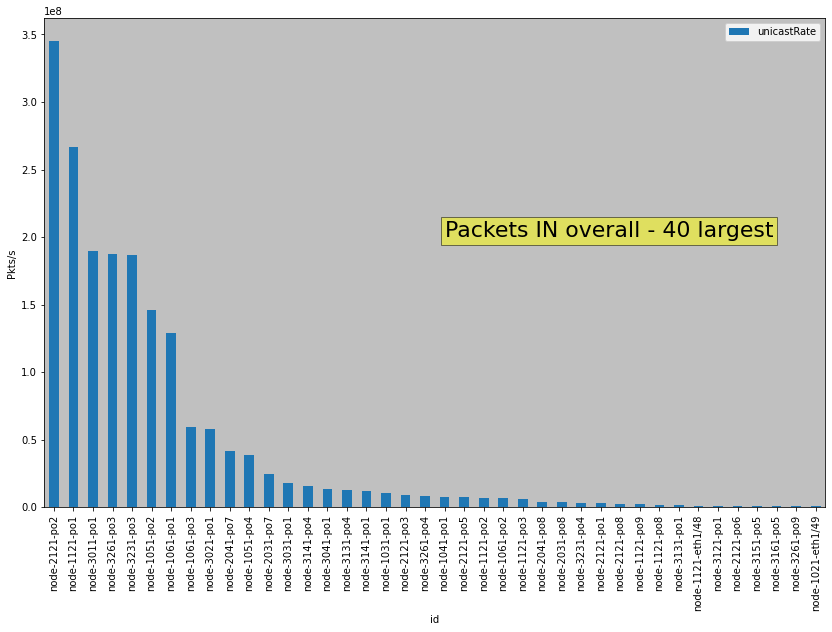

In [6]:
zz = pkts_in_df.head(take)
fig, axs = plt.subplots(figsize=(14, 9))
axs.set_ylabel("Pkts/s")
axs.set_facecolor('silver')
plt.rc('grid', linestyle="-", color='black')
plt.grid(True)

zz.plot.bar(x='id',rot=90,ax=axs)
axs.text(20, 200000000, f"Packets IN overall - {take} largest", fontsize = 22,bbox = dict(facecolor = 'yellow', alpha = 0.5))
fig.savefig(f"results/pkts_in_overall_{dt_string}.png")

## Packets in - physical interfaces  

In [7]:
z_phys_df=pkts_in_df.loc[pkts_in_df['iface'].str.contains("eth")]

In [9]:
take = 40
zz = pkts_in_phys_df.head(take)

NameError: name 'pkts_in_phys_df' is not defined

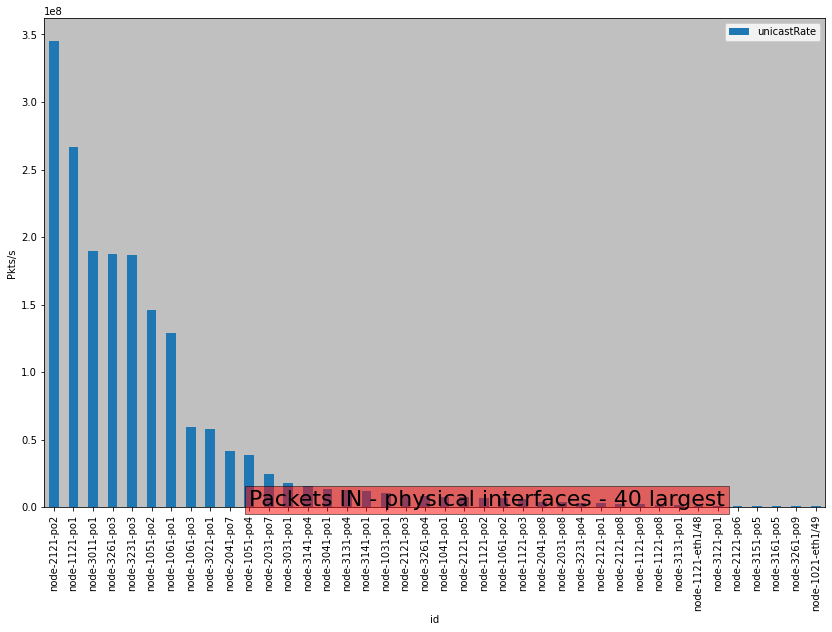

In [10]:
fig, axs = plt.subplots(figsize=(14, 9))
axs.set_ylabel("Pkts/s")
axs.set_facecolor('silver')
plt.rc('grid', linestyle="-", color='black')
plt.grid(True)

zz.plot.bar(x='id',rot=90,ax=axs)
axs.text(10, 700000, f"Packets IN - physical interfaces - {take} largest", fontsize = 22,bbox = dict(facecolor = 'red', alpha = 0.5))
fig.savefig(f"results/pkts_in_physical_{dt_string}.png")

# get unicast ingress bytes

In [ ]:
bytes_in_df = pd.DataFrame(columns=['pod','node','iface','unicastRate'],dtype='str')
bytes_in_df = bytes_in_df.astype({"unicastRate": float})

response = get_data(get_in_bytes_url).json()

pgs = response['imdata']

p1 = re.compile(r'^topology\/(?P<pod>pod\-\d)\/(?P<node>node\-\d*)\/sys\/\S*\-\S*\[(?P<iface>\S*\d)\]')

for pg in pgs:
    unicastRate = pg['eqptIngrBytes5min']['attributes']['unicastRate']
    dn = pg['eqptIngrBytes5min']['attributes']['dn']
    m = p1.match(dn)
    groups = m.groupdict()
    id = groups['node'] + '-' + groups['iface']
    bytes_in_df = bytes_in_df.append({'pod': groups['pod'] , 'node': groups['node'], 'iface': groups['iface'], 'id': id, 'unicastRate': unicastRate },ignore_index=True)
    
    

In [ ]:
bytes_in_df = bytes_in_df.astype({"unicastRate": float})

bytes_in_df['unicastRate'] = bytes_in_df['unicastRate'] /1000000 
bytes_in_df.drop(bytes_in_df[bytes_in_df.unicastRate < 1].index, inplace=True)

bytes_in_df = bytes_in_df.astype({"unicastRate": int})
bytes_in_df= bytes_in_df.sort_values('unicastRate',ascending=False)

In [ ]:
bytes_in_df

In [ ]:
zz = bytes_in_df.head(take)
fig, axs = plt.subplots(figsize=(14, 9))
axs.set_ylabel("Mbytes/s")
axs.set_facecolor('silver')
plt.rc('grid', linestyle="-", color='black')
plt.grid(True)

zz.plot.bar(x='id',rot=90,ax=axs, color='green')
axs.text(20, 120, f"Mbytes/s IN - {take} largest", fontsize = 22,bbox = dict(facecolor = 'orange', alpha = 0.5))
fig.savefig(f"results/mbytes_in_overall_{dt_string}.png")


# get unicast egress packets

In [ ]:
pkts_out_df = pd.DataFrame(columns=['pod','node','iface','unicastRate'],dtype='str')
pkts_out_df = pkts_out_df.astype({"unicastRate": float})

response = get_data(get_out_packets_url).json()

pgs = response['imdata']

p1 = re.compile(r'^topology\/(?P<pod>pod\-\d)\/(?P<node>node\-\d*)\/sys\/\S*\-\S*\[(?P<iface>\S*\d)\]')

for pg in pgs:
    unicastRate = pg['eqptEgrPkts5min']['attributes']['unicastRate']
    dn = pg['eqptEgrPkts5min']['attributes']['dn']
    m = p1.match(dn)
    groups = m.groupdict()
    id = groups['node'] + '-' + groups['iface']
    pkts_out_df = pkts_out_df.append({'pod': groups['pod'] , 'node': groups['node'], 'iface': groups['iface'], 'id': id, 'unicastRate': unicastRate },ignore_index=True)
    
    

In [ ]:
pkts_out_df = pkts_out_df.astype({"unicastRate": float})

pkts_out_df.drop(pkts_out_df[pkts_out_df.unicastRate < 100].index, inplace=True)

pkts_out_df = pkts_out_df.astype({"unicastRate": int})
pkts_out_df= pkts_out_df.sort_values('unicastRate',ascending=False)

## Packets out overall 

In [ ]:
zz = pkts_out_df.head(take)
fig, axs = plt.subplots(figsize=(14, 9))
axs.set_ylabel("Pkts/s")

axs.set_facecolor('silver')
plt.rc('grid', linestyle="-", color='black')
plt.grid(True)

zz.plot.bar(x='id',rot=90,ax=axs,color='red')
axs.text(20, 400000, f"Packets OUT overall - {take} largest", fontsize = 22,bbox = dict(facecolor = 'green', alpha = 0.5))
fig.savefig(f"results/pkts_out_overall_{dt_string}.png")

# get unicast egress bytes

In [ ]:
bytes_out_df = pd.DataFrame(columns=['pod','node','iface','unicastRate'],dtype='str')
bytes_out_df = bytes_out_df.astype({"unicastRate": float})

response = get_data(get_out_bytes_url).json()

pgs = response['imdata']

p1 = re.compile(r'^topology\/(?P<pod>pod\-\d)\/(?P<node>node\-\d*)\/sys\/\S*\-\S*\[(?P<iface>\S*\d)\]')

for pg in pgs:
    unicastRate = pg['eqptEgrBytes5min']['attributes']['unicastRate']
    dn = pg['eqptEgrBytes5min']['attributes']['dn']
    m = p1.match(dn)
    groups = m.groupdict()
    id = groups['node'] + '-' + groups['iface']
    bytes_out_df = bytes_out_df.append({'pod': groups['pod'] , 'node': groups['node'], 'iface': groups['iface'], 'id': id, 'unicastRate': unicastRate },ignore_index=True)
    

In [ ]:
bytes_out_df = bytes_out_df.astype({"unicastRate": float})

bytes_out_df['unicastRate'] = bytes_out_df['unicastRate']/1000000
bytes_out_df.drop(bytes_out_df[bytes_out_df.unicastRate < 2].index, inplace=True)

bytes_out_df = bytes_out_df.astype({"unicastRate": int})
bytes_out_df= bytes_out_df.sort_values('unicastRate',ascending=False)

In [ ]:
bytes_out_df

In [ ]:
zz = bytes_out_df.head(take)
fig, axs = plt.subplots(figsize=(14, 9))
axs.set_ylabel("Mbytes/s")
axs.set_facecolor('silver')
plt.rc('grid', linestyle="-", color='black')
plt.grid(True)

zz.plot.bar(x='id',rot=90,ax=axs, color='orange')
axs.text(20, 220, f"Mbytes/s OUT overall- {take} largest", fontsize = 22,bbox = dict(facecolor = 'gray', alpha = 0.5))
fig.savefig(f"results/mbytes_out_overall_{dt_string}.png")

## Packets in - physical interfaces  

In [ ]:
z_phys_df=bytes_out_df.loc[bytes_out_df['iface'].str.contains("eth")]

In [ ]:
zz = z_phys_df.head(take)
fig, axs = plt.subplots(figsize=(14, 9))
axs.set_ylabel("Mbytes/s")
axs.set_facecolor('silver')
plt.rc('grid', linestyle="-", color='black')
plt.grid(True)


zz.plot.bar(x='id',rot=90,ax=axs, color='blue')
axs.text(10, 220, f"Mbytes/s OUT physical interface- {take} largest", fontsize = 22,bbox = dict(facecolor = 'blue', alpha = 0.5))
fig.savefig(f"results/mbytes_out_physical_{dt_string}.png")

In [ ]:
ls

## SAVE results to file


In [ ]:
pkts_in_df.to_csv(f"results/pkts_in_{dt_string}.csv")
bytes_in_df.to_csv(f"results/mbytes_in_{dt_string}.csv")
pkts_out_df.to_csv(f"results/pkts_out_{dt_string}.csv")
bytes_out_df.to_csv(f"results/bytes_out_{dt_string}.csv")